# Here I consider a spinless fermion jumping between two nodes

1. Hamiltonian
   
    H = a^+_1 a_2 + a^+_2 a_1

2. Jordan-Wigner transformation

    H is transformed into spin Hamiltonian as follows

    1/2 * (X_2 X_1 + Y_2 Y_1) 

3. Note on the anzatz

   The ground state of the Hamiltonian is |01>+|10> which is the entangled state. Therefore, the anzatz should include entangling part.

## Content
1. Ground state of the Hamiltonian above is found
2. Try to found the excited state

 ## Discussion

 1. The VQE gives correct result if the anzatz is chosen correctly. In particular, for this Hamiltonian we must include entangling blocks since the ground state is the entangled state. This is in contrast for example to the case of the domain wall, where the ground state is not entagled and we do not need to include entaglement into the anzatz.
 2. Searching the exciatations is tricky in this case. Since the ground state is degenerate (continously), adding a cost associated with ceratin wave function does not really work.

In [1]:
#Qiskit modules
import qiskit
from qiskit import QuantumRegister as Q_R
from qiskit import ClassicalRegister as C_R
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp

#math modules
import math
# SciPy minimizer routine
from scipy.optimize import minimize

In [66]:
bit_size = 2
# Anzatz assume only unentagled states.
# Since we are trying to get the domain wall we fix the first and last spin states to opposite direcions
def anzatz_qc(theta, bit_size):
    q_r = Q_R(bit_size)
    v_qc = QuantumCircuit(q_r)
    i_theta = 0
    for i in range(0, bit_size):
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.ry(theta[i_theta],i)
        i_theta = i_theta + 1
        v_qc.rx(theta[i_theta],i)
        i_theta = i_theta + 1
    #v_qc.x(bit_size-1)
    for i in range(0, bit_size - 1):
        v_qc.h(i)
        v_qc.cx(i, i + 1)
    #v_qc.cz(bit_size - 1, 0)
        
    return v_qc

## Make Jordan-Wigner transformation myself

In [135]:
# Here I define the Hamiltonian for the qubits
interactions = [("XX", [1, 0], -1)]
interactions.append(("YY", [1, 0], -1))
 
hamiltonian = SparsePauliOp.from_sparse_list(interactions, num_qubits=3)

print(interactions)

[('XX', [1, 0], -1), ('YY', [1, 0], -1)]


In [118]:
# defining a cost function
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def estim(theta, bit_size, hamiltonian):
    v_qc = anzatz_qc(theta, bit_size)
    estimator = StatevectorEstimator()
    job = estimator.run([(v_qc, hamiltonian)])
    estimator_expvals = job.result()[0].data.evs
    #print 
    #print('Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)
    return estimator_expvals

theta = [math.pi, math.pi] * 3
estim(theta, 2, hamiltonian)

array(2.)

In [119]:
#Run COBYLA optimizer
bit_size = 2
#Hamiltonian creation

#Cost history initialization
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

import random
num = random.random()
#print(num)

#initialize the state
x0 = []
for i in range((bit_size)*3):
    x0.append(random.random())

print(x0)
#Optimization
res = minimize(
        estim,
        x0,
        args=(bit_size , hamiltonian),
        method="cobyla",
    )

[0.5255402577675681, 0.05396315096865778, 0.43154700306949134, 0.010667985167183813, 0.03127834146941322, 0.8605212425085386]


In [120]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.999999983926341
       x: [-4.223e-01 -2.182e-05  4.222e-01  1.571e+00  1.505e+00
            1.571e+00]
    nfev: 94
   maxcv: 0.0

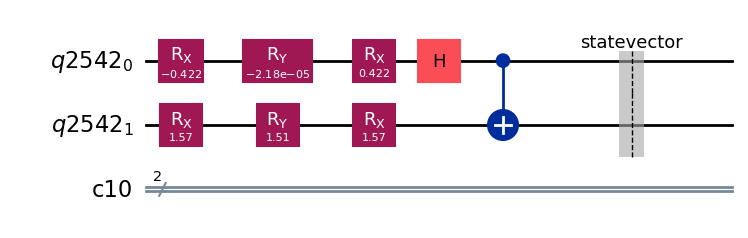

In [121]:
q_r = Q_R(bit_size)
cl_r = C_R(bit_size)
qc_f = QuantumCircuit(q_r,cl_r)
qc_1 = anzatz_qc(res.x, bit_size)
qc_f.append(qc_1, q_r)

#for i in range(bit_size):
#    qc_f.measure(i,i)
SimulatorAer = AerSimulator()

qc_f.save_statevector()

qc_f.decompose().draw('mpl')

Statevector([2.28955407e-05-1.18395656e-05j,
             4.83337455e-01-5.16134533e-01j,
             4.83386724e-01-5.16069106e-01j,
             2.28946452e-05-1.18424137e-05j],
            dims=(2, 2))


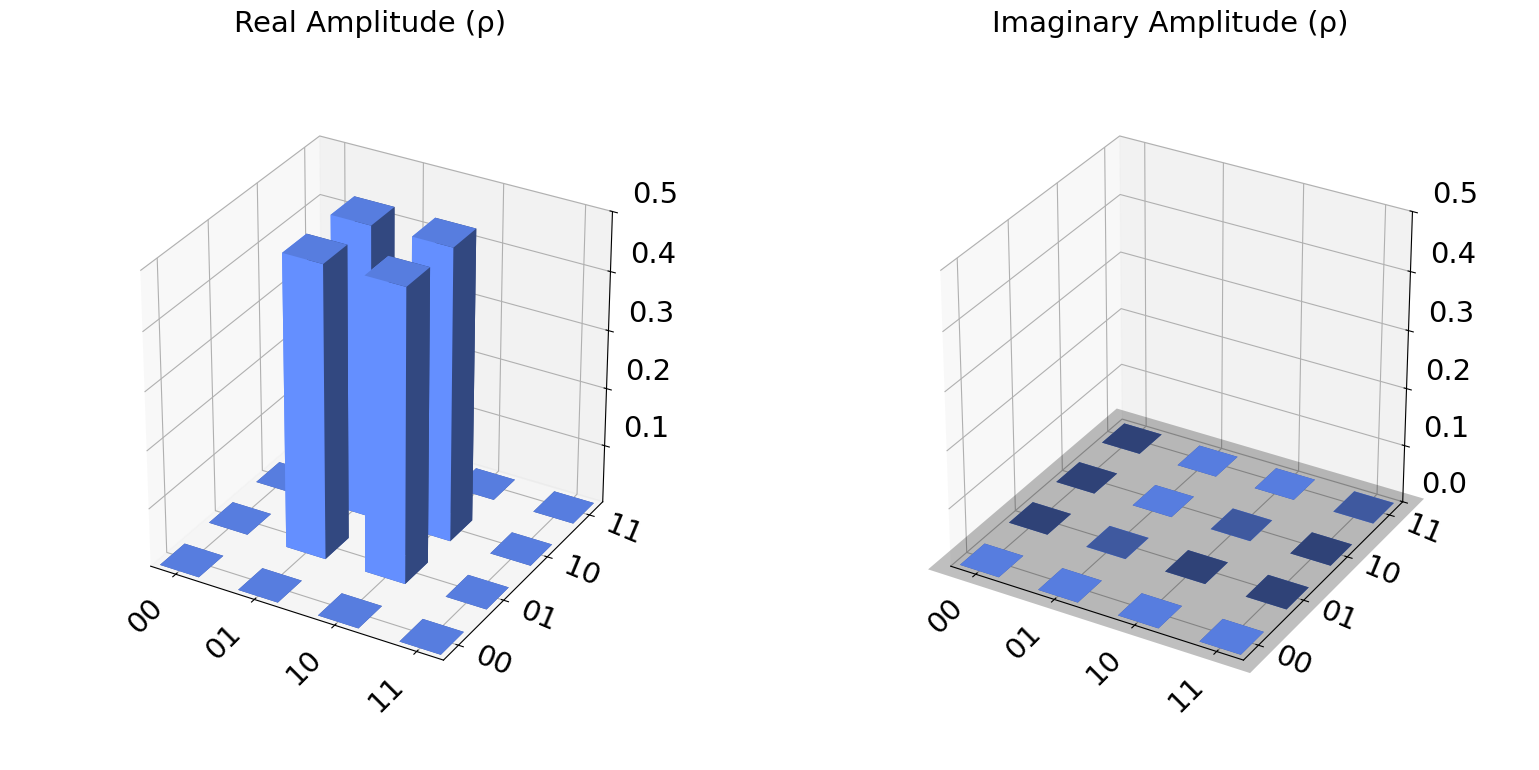

In [123]:
from qiskit.quantum_info import partial_trace, DensityMatrix
from qiskit.visualization import plot_state_city

circ = transpile(qc_f, backend = SimulatorAer)
result = SimulatorAer.run(circ,shots = 1).result()
ground_state = result.get_statevector(circ)
print(ground_state)

dm = DensityMatrix(ground_state)

ground_state.draw(output = 'latex')

plot_state_city(dm)

## Get the 1 excited state

In [131]:
# defining a cost function including the additional term adding a cost for the ground state
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def estim_ex(theta, bit_size, hamiltonian, ground_state, lambda_g):
    v_qc = anzatz_qc(theta, bit_size)
    estimator = StatevectorEstimator()
    job = estimator.run([(v_qc, hamiltonian)])
    estimator_expvals = job.result()[0].data.evs
    #print 
    #print('Energy: ' + str(estimator_expvals))
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta
    cost_history_dict["cost_history"].append(estimator_expvals)

    v_qc.save_statevector()
    circ = transpile(v_qc, backend = SimulatorAer)
    result = SimulatorAer.run(circ, shots = 1).result()
    psi = result.get_statevector(circ)
    proj = psi.inner(ground_state)
    estimator_expvals = estimator_expvals + lambda_g * abs(proj)
    #print(psi)
    #print(ground_state)
    #print(proj)
    
    return estimator_expvals

theta = [math.pi, math.pi] * 3
res = estim_ex(theta, 2, hamiltonian, psi, 100)
res

2.0054303841644345

In [132]:
#Run COBYLA optimizer
bit_size = 2

#Cost history initialization
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

import random
num = random.random()
#print(num)

#initialize the state
x0 = []
for i in range((bit_size)*3):
    x0.append(random.random())

print(x0)
#Optimization
res = minimize(
        estim_ex,
        x0,
        args=(bit_size , hamiltonian, ground_state, 1),
        method="cobyla",
    )

[0.9779625008101492, 0.14104222653276088, 0.2549471877513536, 0.8883939757128579, 0.6713672787778763, 0.8979662849744147]


Statevector([ 1.95044586e-05-4.17321026e-05j,
             -1.05282510e-05-7.07085376e-01j,
             -5.13881382e-05-7.07128181e-01j,
              1.95056891e-05-4.17284493e-05j],
            dims=(2, 2))


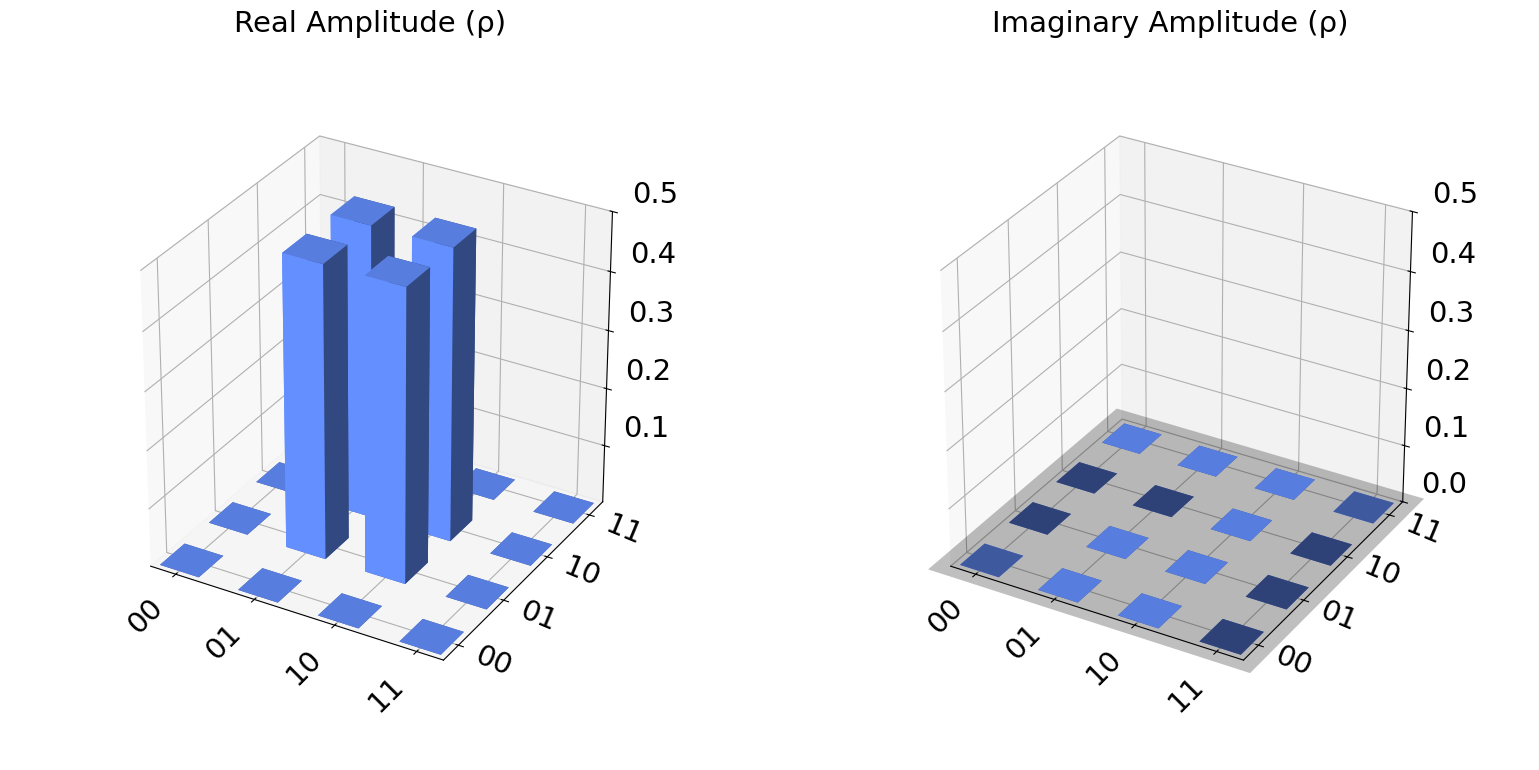

In [133]:
q_r = Q_R(bit_size)
cl_r = C_R(bit_size)
qc_f = QuantumCircuit(q_r,cl_r)
qc_1 = anzatz_qc(res.x, bit_size)
qc_f.append(qc_1, q_r)

#for i in range(bit_size):
#    qc_f.measure(i,i)
SimulatorAer = AerSimulator()

qc_f.save_statevector()

#qc_f.decompose().draw('mpl')

from qiskit.quantum_info import partial_trace, DensityMatrix
from qiskit.visualization import plot_state_city

circ = transpile(qc_f, backend = SimulatorAer)
result = SimulatorAer.run(circ,shots = 1).result()
ex_state = result.get_statevector(circ)
print(ex_state)

dm = DensityMatrix(ex_state)

psi.draw(output = 'latex')

plot_state_city(dm)